# Working with specific observation types
In this demo, you can find a demonstration on how to use Observation types.

In [1]:
import metobs_toolkit

#Initialize an empty Dataset
your_dataset = metobs_toolkit.Dataset()

## Default observation types

An observation record must always be linked to an *observation type* which is specified by the ``Obstype`` class. 
An Obstype represents one observation type (i.g. temperature), and it handles unit conversions and string representations of an observation type. 

By default a set of standard observationtypes are stored in a Dataset:

In [2]:
your_dataset.show()

--------  General --------- 

Empty instance of a Dataset.

 --------  Observation types --------- 

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Farenheit': ['farenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Farenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.
humidity observation with: 
     * standard unit: % 
     * data column as None in None 
     * known units and aliases: {'%': ['percent', 'percentage']} 
     * description: 2m - relative humidity 
     * conversions to known units: {} 
     * originates from data column: None with None as native unit.
radiation_temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius

From the output it is clear that an Obstype holds a **standard unit**. This standard unit is the preferred unit to store and visualize the data in. The toolkit will convert all observations to their standard unit, on all import methods. *(This is also true for the Modeldata, which is converted to the standard units upon import)*.

A **description** (optional) holds a more detailed description of the observation type. 

Multiple **known units** can be defined, as long as the conversion to the standard unit is defined. 

**Aliases** are equivalent names for the same unit. 

At last, each Obstype has a unique **name** for convenions. You can use this name to refer to the Obstype in the Dataset methods.

As an example take a look at the temperature observation and see what the standard unit, other units and aliases looks like:


In [3]:
temperature_obstype = your_dataset.obstypes['temp'] #temp is the name of the observationtype
print(temperature_obstype)

temperature_obstype.get_info()

Obstype instance of temp
temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Farenheit': ['farenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Farenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.


## Creating and Updating observations
If you want to create a new observationtype you can do this by creating an Obstype and adding it to your (empty) Dataset:

In [4]:
co2_concentration = metobs_toolkit.Obstype(obsname='co2',
                                           std_unit='ppm')

#add other units to it (if needed)
co2_concentration.add_unit(unit_name='ppb',
                           conversion=['x / 1000'], #1 ppb = 0.001 ppm
                          )

#Set a description
co2_concentration.set_description(desc='The CO2 concentration measured at 2m above surface')

#add it to your dataset
your_dataset.add_new_observationtype(co2_concentration)

#You can see the CO2 concentration is now added to the dataset
your_dataset.show()
                                           

--------  General --------- 

Empty instance of a Dataset.

 --------  Observation types --------- 

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Farenheit': ['farenheit']} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Farenheit': ['x-32.0', 'x/1.8']} 
     * originates from data column: None with None as native unit.
humidity observation with: 
     * standard unit: % 
     * data column as None in None 
     * known units and aliases: {'%': ['percent', 'percentage']} 
     * description: 2m - relative humidity 
     * conversions to known units: {} 
     * originates from data column: None with None as native unit.
radiation_temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius

You can also update (the units) of the know observationtypes :

In [5]:
your_dataset.add_new_unit(obstype = 'temp', 
                          new_unit= 'your_new_unit',
                          conversion_expression = ['x+3', 'x * 2'])
# The conversion means: 1 [your_new_unit] = (1 + 3) * 2 [°C]
your_dataset.obstypes['temp'].get_info()

temp observation with: 
     * standard unit: Celsius 
     * data column as None in None 
     * known units and aliases: {'Celsius': ['celsius', '°C', '°c', 'celcius', 'Celcius'], 'Kelvin': ['K', 'kelvin'], 'Farenheit': ['farenheit'], 'your_new_unit': []} 
     * description: 2m - temperature 
     * conversions to known units: {'Kelvin': ['x - 273.15'], 'Farenheit': ['x-32.0', 'x/1.8'], 'your_new_unit': ['x+3', 'x * 2']} 
     * originates from data column: None with None as native unit.


## Obstypes for Modeldata

Obstypes are also used in ``Modeldata`` to interpret and convert the modeldata-data. Similar as with a Dataset, a set of default obstypes is stored in each Modeldata. To add a new band, and thus a new obstype, to your modeldata you can you this method:

In [6]:
import pandas as pd
from datetime import datetime
era = metobs_toolkit.Modeldata(modelname='ERA5_hourly')
era.obstypes
#Create a new observation type
precipitation = metobs_toolkit.Obstype(obsname='cumulated_precip',
                                      std_unit='m',
                                      description='Cumulated total precipitation since midnight per squared meter')

#Add it to the Modeldata, and specify the corresponding band.
era.add_obstype(Obstype=precipitation,
                bandname='total_precipitation', #look this up: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY#bands 
                band_units='m',
                band_description="Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). ...",
               )


# Define locations
lat = [50.849]
lon = [4.357]
name = ['Brussels']
metadf = pd.DataFrame(data={'lat': lat,
                            'lon': lon,
                            'name': name})
# Define a time period
tstart = datetime(2023,1,12)
tend = datetime(2023,1,15)


#Extract the data
era.get_gee_dataset_data(mapname='ERA5_hourly',
                         metadf=metadf,
                         startdt_utc=tstart,
                         enddt_utc=tend,
                         obstypes=[precipitation.name]
                        )
era.get_info()


Modeldata instance containing: 
     * Modelname: ERA5_hourly 
     * 1 timeseries 
     * The following obstypes are available: ['cumulated_precip'] 
     * Data has these units: ['m'] 
     * From 2023-01-11 23:00:00+00:00 --> 2023-01-14 23:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)

 ------ Known gee datasets -----------
The following datasets are found: 

 --------------------------------
global_lcz_map : 

 No mapped observation types for global_lcz_map.

 INFO: 

{'location': 'RUB/RUBCLIM/LCZ/global_lcz_map/v1', 'usage': 'LCZ', 'band_of_use': 'LCZ_Filter', 'value_type': 'categorical', 'dynamical': False, 'scale': 100, 'is_image': False, 'is_imagecollection': True, 'categorical_mapper': {1: 'Compact highrise', 2: 'Compact midrise', 3: 'Compact lowrise', 4: 'Open highrise', 5: 'Open midrise', 6: 'Open lowrise', 7: 'Lightweight lowrise', 8: 'Large lowrise', 9: 'Sparsely built', 10: 'Heavy industry', 11: 'Dense Trees (LCZ A)', 12: 'Scattered Trees (LCZ B)', 1

## Special observation types
### 2D-Vector fields
At a specific height, the wind can be seen (by approximation) as a 2D vector field. The vector components are often stored in different bands/variables in a model. 

A common problem is that observation measures the amplitude and direction of a vectorfield, while the models store the vector components. So we need to transform the vector components to an amplitude and direction. 

This can be done in the MetObs toolkit by using the **ModelObstype_Vectorfield**. This class is similar to the ModelObstype class but has the functionality to convert components to amplitude and direction. 

By default, the *wind* obstype is stored in each Modeldata.

In [8]:
era = metobs_toolkit.Modeldata(modelname='ERA5_HOURLY')
era.obstypes['wind_speed'].get_info()

wind_speed observation with: 
     * Known Vector-East-component datasetsbands: {'ERA5_hourly': 'u_component_of_wind_10m'} 
     * Known Vector-North-component datasetsbands: {'ERA5_hourly': 'v_component_of_wind_10m'} 
     * standard unit: m/s 
     * description: wind speed 
     * conversions to known units: {'km/h': ['x / 3.6'], 'mph': ['x * 0.44704']} 



When extracting the wind data from era5 it will
 1. Download the u and v wind components for your period and locations.
 2. Convert each component to its standard units (m/s for the wind components)
 3. Compute the amplitude and the direction (in degrees from North, clockwise).

In [9]:
import pandas as pd
from datetime import datetime

lat = [50.849]
lon = [4.357]
name = ['Brussels']
metadf = pd.DataFrame(data={'lat': lat,
                            'lon': lon,
                            'name': name})

tstart = datetime(2023,1,12)
tend = datetime(2023,1,15)


era.get_gee_dataset_data(mapname='ERA5_hourly',
                         metadf=metadf,
                         startdt_utc=tstart,
                         enddt_utc=tend,
                         obstypes=['wind_speed']
                        )
era

Modeldata instance containing: 
     * Modelname: ERA5_hourly 
     * 1 timeseries 
     * The following obstypes are available: ['wind_speed_amplitude', 'wind_speed_direction'] 
     * Data has these units: ['m/s', '° from north (CW)'] 
     * From 2023-01-11 23:00:00+00:00 --> 2023-01-14 23:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)

<Axes: title={'center': 'ERA5_hourly'}, ylabel='wind_speed_amplitude (m/s) \n ERA5_hourly: u_component_of_wind_10m and v_component_of_wind_10m'>

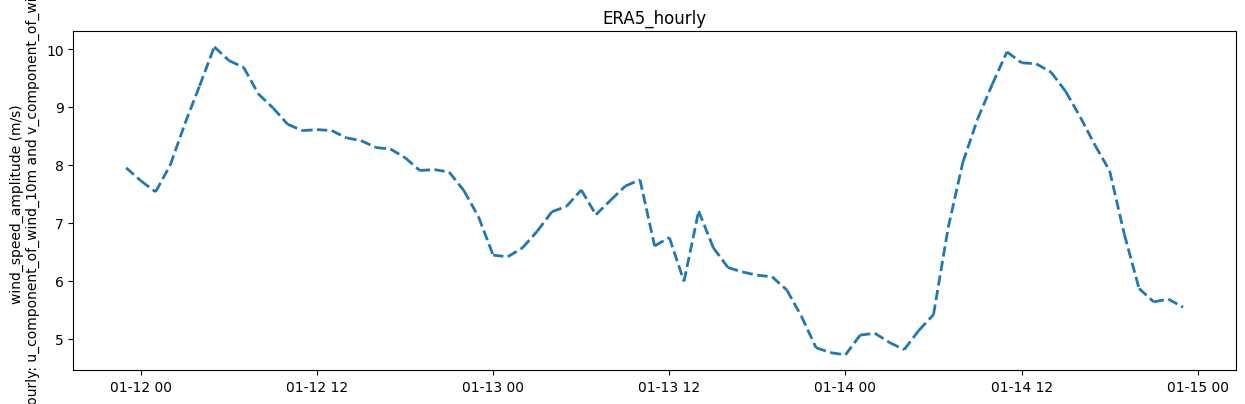

In [11]:
era.make_plot(obstype_model='wind_speed_amplitude')